# LSTM base net Implemented by Keras

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

import tensorflow.keras as keras
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

import ipdb
import dan_utils

In [2]:
# 设置随机数种子
seed = 25
dan_utils.setup_seed(seed)

# Load data

In [3]:
flow_df = pd.read_csv('../data/revised_data/flow_y_revised.csv')
flow = flow_df.to_numpy()
num_det = flow.shape[0]

In [4]:
flow.shape

(40, 4464)

# Data assembling

In [5]:
# # sliding window
# window_size = 10
# pred_size = 20
# train_X = np.zeros([flow.shape[0] - window_size - pred_size + 1, window_size, flow.shape[1]])
# train_y = np.zeros(train_X.shape[0], pred_size)

# for i in range(window_size):
#     train_X[:, i, :] += flow_df.shift(window_size - i - 1).iloc[window_size - 1:, :]
#     # train_y[:, i] += flow_df.shift(window_size - i - 1).iloc[window_size - 1:, :]


In [6]:
def sliding_window(data, window_size, pred_samp, prop):
    
#     data = data.flatten()
    data_out = []
    label_out = []
    for i in range(data.shape[1] - window_size - pred_samp):
        data_out.append(data[:, i : i + window_size])
        # to predict the next [window size] flows
        label_out.append(data[:, i + window_size + 1: i + window_size + 1 + pred_samp])
    data_out = np.array(data_out)
    label_out = np.array(label_out)
#     ipdb.set_trace()
    train_data_out = data_out[:int(data_out.shape[0]*prop), :]
    train_label_out = label_out[:int(data_out.shape[0]*prop)]
    val_data_out = data_out[int(data_out.shape[0]*prop):, :]
    val_label_out = label_out[int(data_out.shape[0]*prop):]
    
    train_data_out = np.transpose(train_data_out, [0, 2, 1])
    train_label_out = np.transpose(train_label_out, [0, 2, 1])
    val_data_out = np.transpose(val_data_out, [0, 2, 1])
    val_label_out = np.transpose(val_label_out, [0, 2, 1])
    
    return train_data_out, train_label_out, val_data_out, val_label_out


In [21]:
window_size = 10
pred_samp = 6

train_X, train_y, test_X, test_y = sliding_window(flow, window_size, pred_samp, 24/31)
# train_X = train_X[-288:, :, :]
# train_y = train_y[-288:, :, :]

In [22]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(3443, 10, 40)
(3443, 6, 40)
(1005, 10, 40)
(1005, 6, 40)


# LSTM network (base)

In [23]:
# data at the position of "number of detectors" are the same
assert train_X.shape[2] == train_y.shape[2]
assert train_X.shape[2] == test_X.shape[2]
assert train_X.shape[2] == test_y.shape[2]
num_det = flow.shape[0]

hid_dim = 40

In [24]:
train_X.shape

(3443, 10, 40)

In [25]:
model = keras.models.Sequential()
# out shape: [window_size, hid_dim]
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LSTM(units=hid_dim, return_sequences=True))
model.add(keras.layers.LSTM(units=hid_dim, return_sequences=True))
model.add(keras.layers.LSTM(units=hid_dim, return_sequences=True))
model.add(keras.layers.Lambda(lambda x: x[:, -pred_samp:, :]))
# model.add(keras.layers.RepeatVector(pred_samp))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(num_det, activation='relu'))

# Training on target data

In [26]:
test_y.shape

(1005, 6, 40)

In [27]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_X, train_y, epochs=800, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=True)

Epoch 1/800
27/27 - 4s - loss: 239876.2500 - val_loss: 242169.9219
Epoch 2/800
27/27 - 0s - loss: 239194.7812 - val_loss: 241118.2812
Epoch 3/800
27/27 - 0s - loss: 238390.3281 - val_loss: 240017.9688
Epoch 4/800
27/27 - 0s - loss: 237536.3438 - val_loss: 238904.6406
Epoch 5/800
27/27 - 0s - loss: 236626.5156 - val_loss: 237778.2031
Epoch 6/800
27/27 - 0s - loss: 235639.9688 - val_loss: 236821.1250
Epoch 7/800
27/27 - 0s - loss: 234533.4375 - val_loss: 235732.7812
Epoch 8/800
27/27 - 0s - loss: 233377.0156 - val_loss: 234617.6250
Epoch 9/800
27/27 - 0s - loss: 232124.2500 - val_loss: 233351.8125
Epoch 10/800
27/27 - 0s - loss: 230755.6875 - val_loss: 231889.6562
Epoch 11/800
27/27 - 0s - loss: 229302.6094 - val_loss: 229835.1094
Epoch 12/800
27/27 - 0s - loss: 227756.6562 - val_loss: 228056.6719
Epoch 13/800
27/27 - 0s - loss: 226100.5000 - val_loss: 226589.7031
Epoch 14/800
27/27 - 0s - loss: 224341.2031 - val_loss: 224189.2969
Epoch 15/800
27/27 - 0s - loss: 222688.7031 - val_loss: 2

Epoch 123/800
27/27 - 0s - loss: 89076.9062 - val_loss: 88727.7344
Epoch 124/800
27/27 - 0s - loss: 88918.4766 - val_loss: 88526.1641
Epoch 125/800
27/27 - 0s - loss: 88852.5312 - val_loss: 88576.8359
Epoch 126/800
27/27 - 0s - loss: 89011.0547 - val_loss: 88706.5547
Epoch 127/800
27/27 - 0s - loss: 89847.3750 - val_loss: 90899.3594
Epoch 128/800
27/27 - 0s - loss: 89158.2266 - val_loss: 88451.4609
Epoch 129/800
27/27 - 0s - loss: 89043.9766 - val_loss: 88483.2969
Epoch 130/800
27/27 - 0s - loss: 88880.1641 - val_loss: 88637.1484
Epoch 131/800
27/27 - 0s - loss: 89184.3281 - val_loss: 88812.4922
Epoch 132/800
27/27 - 0s - loss: 88941.1172 - val_loss: 88338.7812
Epoch 133/800
27/27 - 0s - loss: 89022.2422 - val_loss: 89062.0234
Epoch 134/800
27/27 - 0s - loss: 89056.3359 - val_loss: 88502.5000
Epoch 135/800
27/27 - 0s - loss: 89432.7031 - val_loss: 90849.2500
Epoch 136/800
27/27 - 0s - loss: 89278.0000 - val_loss: 88395.3359
Epoch 137/800
27/27 - 0s - loss: 88805.1016 - val_loss: 88847.

Epoch 246/800
27/27 - 0s - loss: 75363.5859 - val_loss: 77045.8438
Epoch 247/800
27/27 - 0s - loss: 72219.8281 - val_loss: 69372.2578
Epoch 248/800
27/27 - 0s - loss: 69064.0312 - val_loss: 68632.5859
Epoch 249/800
27/27 - 0s - loss: 66758.4922 - val_loss: 67489.6250
Epoch 250/800
27/27 - 0s - loss: 64644.8359 - val_loss: 65530.3711
Epoch 251/800
27/27 - 0s - loss: 62642.9414 - val_loss: 63066.2070
Epoch 252/800
27/27 - 0s - loss: 60852.0898 - val_loss: 61100.4492
Epoch 253/800
27/27 - 0s - loss: 59112.3125 - val_loss: 58630.2031
Epoch 254/800
27/27 - 0s - loss: 57648.7383 - val_loss: 57456.8203
Epoch 255/800
27/27 - 0s - loss: 56164.7305 - val_loss: 56321.6992
Epoch 256/800
27/27 - 0s - loss: 54993.6719 - val_loss: 55344.0273
Epoch 257/800
27/27 - 0s - loss: 53965.4023 - val_loss: 54182.6797
Epoch 258/800
27/27 - 0s - loss: 52746.0117 - val_loss: 53656.8398
Epoch 259/800
27/27 - 0s - loss: 51825.6016 - val_loss: 52639.8906
Epoch 260/800
27/27 - 0s - loss: 50843.9258 - val_loss: 51876.

Epoch 369/800
27/27 - 0s - loss: 24568.2207 - val_loss: 26311.4844
Epoch 370/800
27/27 - 0s - loss: 24433.8047 - val_loss: 26271.4902
Epoch 371/800
27/27 - 0s - loss: 24361.9805 - val_loss: 26246.7539
Epoch 372/800
27/27 - 0s - loss: 24365.8320 - val_loss: 26162.3203
Epoch 373/800
27/27 - 0s - loss: 24322.2676 - val_loss: 26125.5039
Epoch 374/800
27/27 - 0s - loss: 24348.1641 - val_loss: 26232.2305
Epoch 375/800
27/27 - 0s - loss: 24220.7266 - val_loss: 26096.1445
Epoch 376/800
27/27 - 0s - loss: 24203.2598 - val_loss: 26012.8203
Epoch 377/800
27/27 - 0s - loss: 24120.8945 - val_loss: 25973.1855
Epoch 378/800
27/27 - 0s - loss: 24204.8906 - val_loss: 25893.0938
Epoch 379/800
27/27 - 0s - loss: 24064.8301 - val_loss: 25970.4668
Epoch 380/800
27/27 - 0s - loss: 24000.0586 - val_loss: 25939.3906
Epoch 381/800
27/27 - 0s - loss: 24066.6582 - val_loss: 25859.7012
Epoch 382/800
27/27 - 0s - loss: 23887.4141 - val_loss: 25905.7305
Epoch 383/800
27/27 - 0s - loss: 23967.5352 - val_loss: 25851.

Epoch 492/800
27/27 - 0s - loss: 14561.7158 - val_loss: 16316.9346
Epoch 493/800
27/27 - 0s - loss: 14458.0752 - val_loss: 16318.6416
Epoch 494/800
27/27 - 0s - loss: 14383.9990 - val_loss: 16261.1719
Epoch 495/800
27/27 - 0s - loss: 14230.0791 - val_loss: 16466.0605
Epoch 496/800
27/27 - 0s - loss: 13959.3457 - val_loss: 16042.3818
Epoch 497/800
27/27 - 0s - loss: 13619.7246 - val_loss: 15559.3203
Epoch 498/800
27/27 - 0s - loss: 13426.0693 - val_loss: 15855.1914
Epoch 499/800
27/27 - 0s - loss: 13163.6562 - val_loss: 15356.4463
Epoch 500/800
27/27 - 0s - loss: 12590.7822 - val_loss: 13098.5166
Epoch 501/800
27/27 - 0s - loss: 11940.1943 - val_loss: 12068.3809
Epoch 502/800
27/27 - 0s - loss: 11483.2471 - val_loss: 11585.3057
Epoch 503/800
27/27 - 0s - loss: 10609.4375 - val_loss: 11718.0654
Epoch 504/800
27/27 - 0s - loss: 9925.4844 - val_loss: 12460.8486
Epoch 505/800
27/27 - 0s - loss: 9771.2773 - val_loss: 13313.5820
Epoch 506/800
27/27 - 0s - loss: 9148.7236 - val_loss: 11260.793

Epoch 618/800
27/27 - 0s - loss: 2761.4731 - val_loss: 4570.8491
Epoch 619/800
27/27 - 0s - loss: 2754.6902 - val_loss: 4540.0713
Epoch 620/800
27/27 - 0s - loss: 2613.4475 - val_loss: 4493.5254
Epoch 621/800
27/27 - 0s - loss: 2751.6565 - val_loss: 4571.2949
Epoch 622/800
27/27 - 0s - loss: 2619.5740 - val_loss: 4552.4263
Epoch 623/800
27/27 - 0s - loss: 2693.7261 - val_loss: 4535.5684
Epoch 624/800
27/27 - 0s - loss: 2691.4717 - val_loss: 4546.6729
Epoch 625/800
27/27 - 0s - loss: 2647.2529 - val_loss: 4512.6060
Epoch 626/800
27/27 - 0s - loss: 2514.4658 - val_loss: 4837.8096
Epoch 627/800
27/27 - 0s - loss: 2664.6523 - val_loss: 4502.2197
Epoch 628/800
27/27 - 0s - loss: 2616.4417 - val_loss: 4507.0029
Epoch 629/800
27/27 - 0s - loss: 2683.1902 - val_loss: 4635.3911
Epoch 630/800
27/27 - 0s - loss: 2525.7942 - val_loss: 4672.7964
Epoch 631/800
27/27 - 0s - loss: 2518.5059 - val_loss: 4589.2344
Epoch 632/800
27/27 - 0s - loss: 2480.7490 - val_loss: 4650.1689
Epoch 633/800
27/27 - 0s 

27/27 - 0s - loss: 2430.1938 - val_loss: 4389.3535
Epoch 745/800
27/27 - 0s - loss: 2260.0708 - val_loss: 4528.0732
Epoch 746/800
27/27 - 0s - loss: 2314.9016 - val_loss: 4476.7402
Epoch 747/800
27/27 - 0s - loss: 2229.1299 - val_loss: 4322.6807
Epoch 748/800
27/27 - 0s - loss: 2407.9890 - val_loss: 4326.4756
Epoch 749/800
27/27 - 0s - loss: 2305.2656 - val_loss: 4491.7188
Epoch 750/800
27/27 - 0s - loss: 2296.6602 - val_loss: 4311.4175
Epoch 751/800
27/27 - 0s - loss: 2179.6455 - val_loss: 4349.4233
Epoch 752/800
27/27 - 0s - loss: 2465.6650 - val_loss: 4203.2466
Epoch 753/800
27/27 - 0s - loss: 2305.8071 - val_loss: 4432.5176
Epoch 754/800
27/27 - 0s - loss: 2137.8064 - val_loss: 4179.7979
Epoch 755/800
27/27 - 0s - loss: 2385.8872 - val_loss: 4371.2949
Epoch 756/800
27/27 - 0s - loss: 2401.5105 - val_loss: 4279.8667
Epoch 757/800
27/27 - 0s - loss: 2254.8220 - val_loss: 4312.0957
Epoch 758/800
27/27 - 0s - loss: 2315.2651 - val_loss: 4382.4844
Epoch 759/800
27/27 - 0s - loss: 2227.9

# Visualization

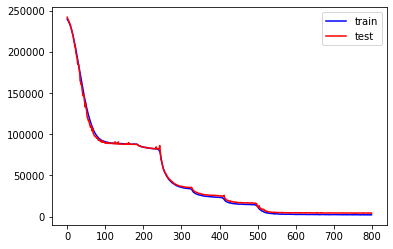

In [28]:
p1 = plt.plot(history.history['loss'], color='blue', label='train')
p2 = plt.plot(history.history['val_loss'], color='red',label='test')
plt.legend()

In [29]:
yhat = model.predict(test_X)

In [30]:
test_y.shape

(1005, 6, 40)

Text(0.5, 1.0, 'Testing dataset')

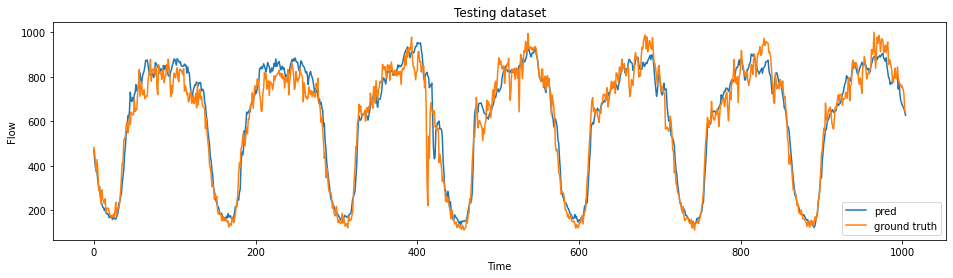

In [31]:
n_step_ahead = 1
det = 0

plt.figure(figsize=[16,4])
plt.plot(yhat[:, n_step_ahead, det], label='pred')
plt.plot(test_y[:, n_step_ahead, det], label='ground truth')
plt.legend()
plt.xlabel('Time')  # time gran: 10 min
plt.ylabel('Flow')
plt.title('Testing dataset')

# Evaluation

In [32]:
#transfer with DAN 预测精度计算
m=0
model_pre = yhat
label_test_target = test_y

nrmse_mean = dan_utils.nrmse_loss_func(model_pre, label_test_target, m)
mape_mean = dan_utils.mape_loss_func(model_pre, label_test_target, m)
smape_mean = dan_utils.smape_loss_func(model_pre, label_test_target, m)
mae_mean = dan_utils.mae_loss_func(model_pre, label_test_target, m)

print('nrmse = ' + str(nrmse_mean) + '\n' + 'mape = ' + str(mape_mean) + '\n' + 'smape = ' + str(smape_mean) + '\n' + 'mae = ' + str(mae_mean))

nrmse = 0.1338860712209251
mape = 0.1663410045434726
smape = 0.07118700940141552
mae = 45.64336750094085


In [33]:
# np.save('../res/lstm/24d.npy', model_pre)